In [1]:
import os 
import pandas as pd 
import numpy as np 
import tejapi

os.environ['TEJAPI_KEY'] = "your key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

os.environ['mdate'] = '20180101 20201231'
os.environ['ticker'] = 'IR0001 2317 2324 2327 2330 2347 2353 2354 2357 2379 2382 2395'

!zipline ingest -b tquant

[2024-02-07 02:36:55.741346] INFO: zipline.data.bundles.core: Ingesting tquant.

Merging daily equity files:
Currently used TEJ API key call quota 213/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 23898875/9223372036854775807 (0.0%)



[2024-02-07 02:37:06.324771] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [2]:
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record
from zipline.finance import commission, slippage
from zipline.data import bundles
from zipline import run_algorithm
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.filters import StaticAssets, StaticSids
from zipline.pipeline.factors import BollingerBands, Aroon
from zipline.pipeline.data import EquityPricing

from zipline.pipeline.mixins import LatestMixin

from zipline.master import run_pipeline

In [3]:
bundle = bundles.load('tquant')
ir0001_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

In [4]:

def make_pipeline():
    curr_price = EquityPricing.close.latest
    
    alroon = Aroon(inputs = [EquityPricing.low, EquityPricing.high], window_length=25, mask = curr_price < 5000)
    up, down = alroon.up, alroon.down
    

    return Pipeline(
        columns = {
            'up':  up,
            'down':  down,
            'curr_price': curr_price,

        },
        screen = ~StaticAssets([ir0001_asset])
    )

def initialize(context):
    context.last_buy_price = 0
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('IR0001'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_signal_price = 0
    
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')
    for i in out_dir.index: 
        sym = i.symbol # 標的代碼
        up = out_dir.loc[i, 'up']
        down = out_dir.loc[i, 'down']
        curr_price = out_dir.loc[i, 'curr_price']

        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount

        buy, sell = False, False

        record(
            **{
                f'price_{sym}':curr_price,
                f'up_{sym}':up,
                f'down_{sym}':down,
                f'buy_{sym}':buy,
                f'sell_{sym}':sell
            }
        )

        if stock_position == 0:
            if down < 45 and up > 80:
                order(i, 1000)
                context.last_signal_price = curr_price
                buy = True
                record(
                    **{
                        f'buy_{sym}':buy
                    }
                )              

        elif stock_position > 0:
            if (up - down) > 15 and (down < 45) and (up > 55) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                context.last_signal_price = curr_price
                buy = True
                record(
                    #globals()[f'buy_{sym}'] = buy
                    **{
                        f'buy_{sym}':buy
                    }
                )

            elif (down - up > 15) and (down > 55) and (up < 45):
                order_target(i, 0)
                context.last_signal_price = 0
                sell = True
                record(
                    **{
                        f'sell_{sym}':sell
                    }
                )
            else:
                pass
        else:
            pass

def analyze(context, perf):
    pass

results = run_algorithm(
    start = pd.Timestamp('2018-01-01', tz='UTC'),
    end = pd.Timestamp('2020-12-31', tz ='UTC'),
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=10e6,
    handle_data = handle_data
)

results

,period_open,period_close,longs_count,shorts_count,treasury_return,positions,long_value,short_value,long_exposure,pnl,...,price_2382,up_2382,down_2382,buy_2382,sell_2382,price_2395,up_2395,down_2395,buy_2395,sell_2395
2018-01-02 13:30:00+08:00,2018-01-02 09:01:00+08:00,2018-01-02 13:30:00+08:00,0,0,0.0,[],0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 13:30:00+08:00,2018-01-03 09:01:00+08:00,2018-01-03 13:30:00+08:00,0,0,0.0,[],0.0,0.0,0.0,0.000000,...,61.9,100.000000,100.000000,False,False,215.0,100.000000,100.000000,False,False
2018-01-04 13:30:00+08:00,2018-01-04 09:01:00+08:00,2018-01-04 13:30:00+08:00,0,0,0.0,[],0.0,0.0,0.0,0.000000,...,62.6,100.000000,95.833333,False,False,216.5,100.000000,95.833333,False,False
2018-01-05 13:30:00+08:00,2018-01-05 09:01:00+08:00,2018-01-05 13:30:00+08:00,0,0,0.0,[],0.0,0.0,0.0,0.000000,...,62.9,95.833333,91.666667,False,False,213.5,95.833333,91.666667,False,False
2018-01-08 13:30:00+08:00,2018-01-08 09:01:00+08:00,2018-01-08 13:30:00+08:00,0,0,0.0,[],0.0,0.0,0.0,0.000000,...,61.8,91.666667,87.500000,False,False,216.0,91.666667,87.500000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25 13:30:00+08:00,2020-12-25 09:01:00+08:00,2020-12-25 13:30:00+08:00,10,1,0.0,"[{'sid': Equity(10 [2395]), 'amount': -14162, ...",31849850.0,-4652217.0,31849850.0,64998.000000,...,78.8,50.000000,0.000000,False,False,332.5,83.333333,16.666667,False,False
2020-12-28 13:30:00+08:00,2020-12-28 09:01:00+08:00,2020-12-28 13:30:00+08:00,10,1,0.0,"[{'sid': Equity(10 [2395]), 'amount': -14162, ...",31953600.0,-4744270.0,31953600.0,11697.000000,...,79.8,45.833333,20.833333,False,False,328.5,79.166667,12.500000,False,False
2020-12-29 13:30:00+08:00,2020-12-29 09:01:00+08:00,2020-12-29 13:30:00+08:00,9,1,0.0,"[{'sid': Equity(10 [2395]), 'amount': -14162, ...",31002200.0,-4829242.0,31002200.0,-128622.029912,...,80.9,41.666667,16.666667,False,False,335.0,75.000000,8.333333,False,False
2020-12-30 13:30:00+08:00,2020-12-30 09:01:00+08:00,2020-12-30 13:30:00+08:00,9,1,0.0,"[{'sid': Equity(10 [2395]), 'amount': -14162, ...",32166800.0,-4942538.0,32166800.0,500542.595452,...,80.4,37.500000,12.500000,False,False,341.0,70.833333,4.166667,False,False


In [5]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# 時區標準化
returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')

In [6]:
returns

2018-01-02 00:00:00+00:00    0.000000
2018-01-03 00:00:00+00:00    0.000000
2018-01-04 00:00:00+00:00    0.000000
2018-01-05 00:00:00+00:00    0.000000
2018-01-08 00:00:00+00:00    0.000000
                               ...   
2020-12-25 00:00:00+00:00    0.002410
2020-12-28 00:00:00+00:00    0.000433
2020-12-29 00:00:00+00:00   -0.004755
2020-12-30 00:00:00+00:00    0.018592
2020-12-31 00:00:00+00:00   -0.001871
Name: returns, Length: 734, dtype: float64

In [7]:
from pyfolio.plotting import show_perf_stats
perf_stats = show_perf_stats(
    returns, 
    benchmark_rets, 
    positions, 
    transactions, 
    turnover_denom='portfolio_value',
    live_start_date=pd.Timestamp('2020-01-01', tz='UTC'),
    bootstrap=True,
    header_rows={'Portfolio name': "Aroon strategy"}
)

In [8]:
from pyfolio.plotting import show_worst_drawdown_periods
show_worst_drawdown_periods(returns, top=10)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.63,2018-06-07,2018-06-22,2019-02-14,170
1,19.92,2019-05-07,2019-08-20,2019-12-17,155
2,15.00,2020-01-03,2020-05-18,2020-07-03,118
3,13.65,2018-05-15,2018-05-17,2018-05-28,10
4,12.25,2018-05-29,2018-05-31,2018-06-06,7
5,12.13,2020-08-06,2020-09-09,2020-12-09,87
6,11.76,2018-04-23,2018-04-25,2018-05-07,10
7,6.54,2019-02-26,2019-03-08,2019-04-15,31
8,5.89,2020-12-11,2020-12-22,NaT,NaN
9,5.72,2018-01-26,2018-02-09,2018-03-29,38


Stress Events,mean,min,max
New Normal,0.15%,-8.86%,9.43%


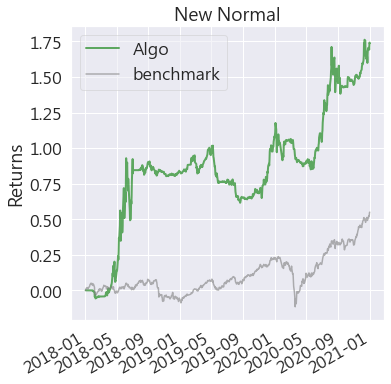

In [9]:
from pyfolio.tears import create_interesting_times_tear_sheet
create_interesting_times_tear_sheet(returns, benchmark_rets)

Top 10 long positions of all time,max
sid,
2327,95.95%
2379,78.16%
2330,71.14%
2357,33.35%
2395,22.71%
2382,19.09%
2317,11.70%
2354,10.52%
2347,8.37%


Top 10 short positions of all time,max
sid,
2395,-23.93%


Top 10 positions of all time,max
sid,
2327,95.95%
2379,78.16%
2330,71.14%
2357,33.35%
2395,23.93%
2382,19.09%
2317,11.70%
2354,10.52%
2347,8.37%


<AxesSubplot:title={'center':'Portfolio allocation over time, only top 10 holdings'}, xlabel='index', ylabel='Exposure by holding'>

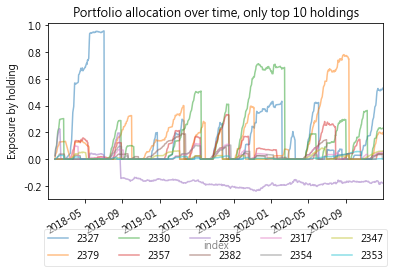

In [10]:
from pyfolio.plotting import show_and_plot_top_positions
import pyfolio
show_and_plot_top_positions(returns, positions_alloc=pyfolio.pos.get_percent_alloc(positions))

In [11]:
from pyfolio.pos import get_percent_alloc
get_percent_alloc(positions)

sid,Equity(0 [2317]),Equity(1 [2324]),Equity(2 [2327]),Equity(3 [2330]),Equity(4 [2347]),Equity(5 [2353]),Equity(6 [2354]),Equity(7 [2357]),Equity(8 [2379]),Equity(9 [2382]),Equity(10 [2395]),cash
index,,,,,,,,,,,,
2018-01-24 00:00:00+00:00,0.000000,0.000000,0.000000,0.025800,0.000000,0.000000,0.000000,0.000000,0.012200,0.000000,0.023500,0.938500
2018-01-25 00:00:00+00:00,0.000000,0.000000,0.000000,0.051592,0.000000,0.002795,0.000000,0.000000,0.024596,0.000000,0.047093,0.873924
2018-01-26 00:00:00+00:00,0.000000,0.000000,0.000000,0.076484,0.000000,0.005519,0.000000,0.000000,0.037792,0.000000,0.070785,0.809420
2018-01-29 00:00:00+00:00,0.000000,0.000000,0.000000,0.103464,0.000000,0.008390,0.000000,0.000000,0.049831,0.000000,0.092457,0.745858
2018-01-30 00:00:00+00:00,0.000000,0.000000,0.000000,0.127189,0.000000,0.010979,0.000000,0.000000,0.061081,0.000000,0.114621,0.686130
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25 00:00:00+00:00,0.050925,0.016760,0.517755,0.226777,0.058721,0.002635,0.033761,0.036687,0.192549,0.041317,-0.172051,-0.005837
2020-12-28 00:00:00+00:00,0.050903,0.016916,0.519601,0.228453,0.059135,0.002650,0.033935,0.036967,0.190784,0.041868,-0.175379,-0.005834
2020-12-29 00:00:00+00:00,0.050366,0.017119,0.526244,0.229544,0.059228,0.002641,0.000000,0.037217,0.187350,0.041808,-0.179373,0.027855


<AxesSubplot:ylabel='Cumulative returns'>

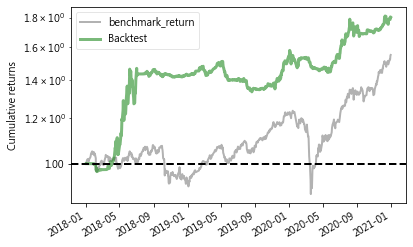

In [12]:
from pyfolio.plotting import plot_rolling_returns
plot_rolling_returns(returns,
                     benchmark_rets, 
                     live_start_date=pd.Timestamp('2021-07-03'),
                     logy=True,
                     cone_std=(1., 1.5, 2.),
                     volatility_match=True
                    )

<AxesSubplot:ylabel='Returns'>

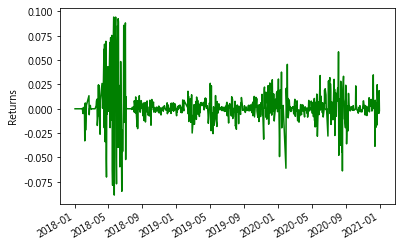

In [13]:
from pyfolio.plotting import plot_returns
plot_returns(returns, live_start_date=pd.Timestamp('2021-07-03'))

<AxesSubplot:title={'center':'Rolling portfolio beta to benchmark_return'}, ylabel='Beta'>

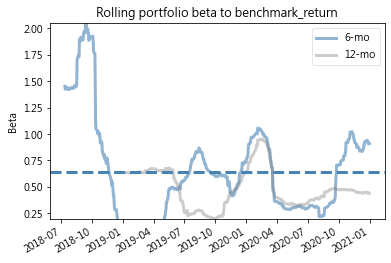

In [14]:
from pyfolio.plotting import plot_rolling_beta
plot_rolling_beta(returns, 
                  factor_returns=benchmark_rets
                 )

<AxesSubplot:title={'center':'Top 10 drawdown periods'}, ylabel='Cumulative returns'>

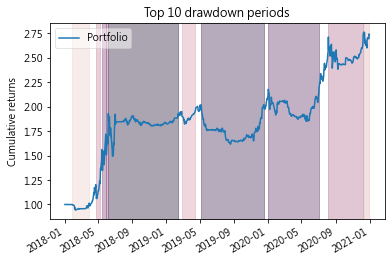

In [15]:
import pyfolio
pyfolio.plotting.plot_drawdown_periods(returns)

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

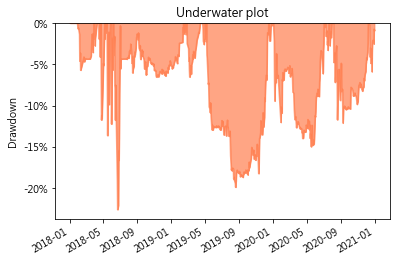

In [16]:
pyfolio.plotting.plot_drawdown_underwater(returns)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

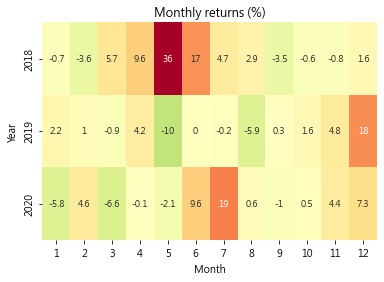

In [17]:
pyfolio.plotting.plot_monthly_returns_heatmap(returns)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

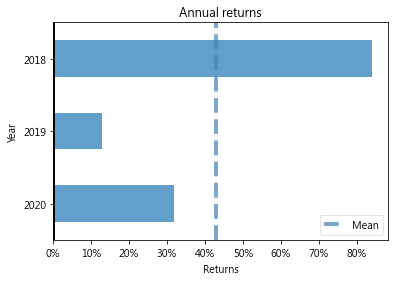

In [18]:
pyfolio.plotting.plot_annual_returns(returns)

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

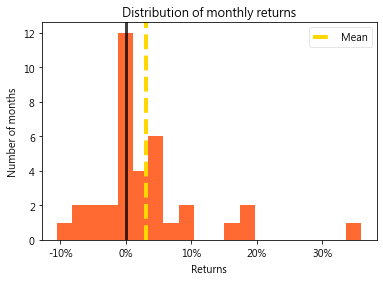

In [19]:
pyfolio.plotting.plot_monthly_returns_dist(returns)

<AxesSubplot:title={'center':'Return quantiles'}>

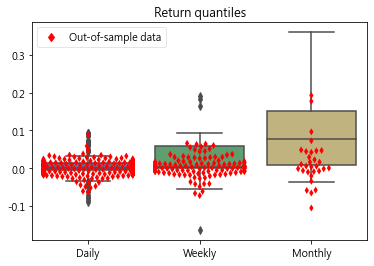

In [20]:
pyfolio.plotting.plot_return_quantiles(returns, live_start_date=pd.Timestamp("2018-07-02", tz='UTC'))

<AxesSubplot:title={'center':'Exposure'}, ylabel='Exposure'>

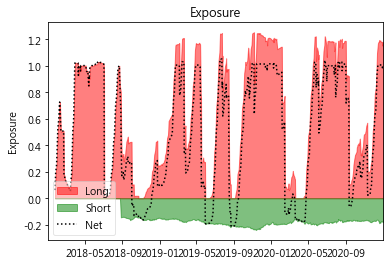

In [21]:
pyfolio.plotting.plot_exposures(returns, positions)

<AxesSubplot:title={'center':'Long/short max and median position concentration'}, xlabel='index', ylabel='Exposure'>

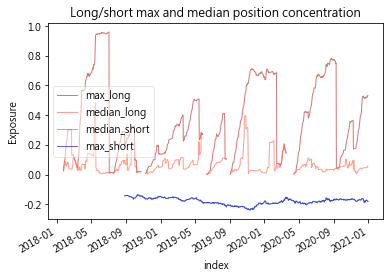

In [22]:
pyfolio.plotting.plot_max_median_position_concentration(positions)

<AxesSubplot:title={'center':'Total holdings'}, ylabel='Holdings'>

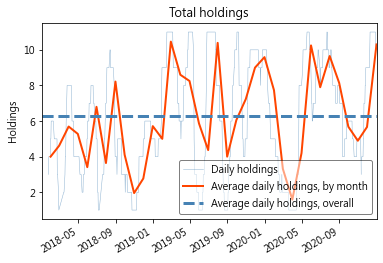

In [23]:
pyfolio.plotting.plot_holdings(returns, positions)

<AxesSubplot:title={'center':'Long and short holdings'}, ylabel='Holdings'>

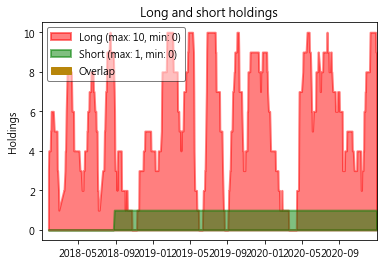

In [24]:
pyfolio.plotting.plot_long_short_holdings(returns, positions)

<AxesSubplot:title={'center':'Gross leverage'}, ylabel='Gross leverage'>

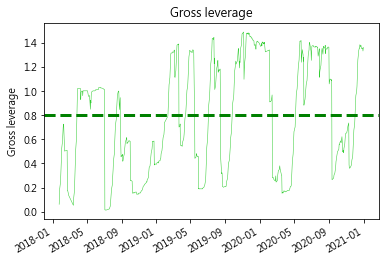

In [25]:
pyfolio.plotting.plot_gross_leverage(returns, positions)

<AxesSubplot:title={'center':'Daily turnover'}, ylabel='Turnover'>

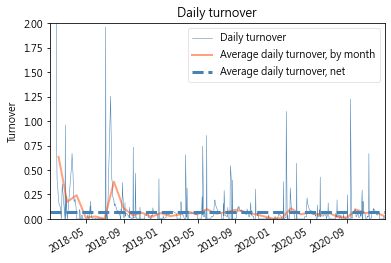

In [26]:
pyfolio.plotting.plot_turnover(returns, transactions, positions)

<AxesSubplot:title={'center':'Daily trading volume'}, ylabel='Amount of shares traded'>

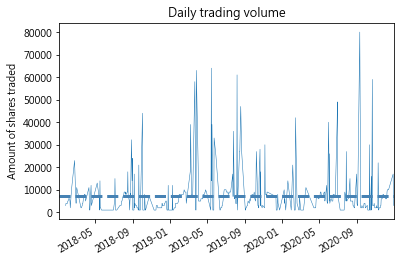

In [27]:
pyfolio.plotting.plot_daily_volume(returns, transactions)

<AxesSubplot:title={'center':'Distribution of daily turnover rates'}, xlabel='Turnover rate', ylabel='Count'>

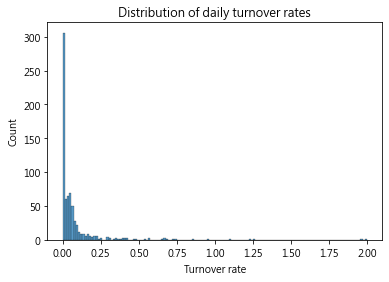

In [28]:
pyfolio.plotting.plot_daily_turnover_hist(transactions, positions)

Start date,2018-01-02
End date,2020-12-31
Total months,34
,Backtest
Annual return,41.299%
Cumulative returns,173.721%
Annual volatility,29.537%
Sharpe ratio,1.32
Calmar ratio,1.82
Stability,0.63
Max drawdown,-22.631%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.63,2018-06-07,2018-06-22,2019-02-14,170
1,19.92,2019-05-07,2019-08-20,2019-12-17,155
2,15.00,2020-01-03,2020-05-18,2020-07-03,118
3,13.65,2018-05-15,2018-05-17,2018-05-28,10
4,12.25,2018-05-29,2018-05-31,2018-06-06,7


Stress Events,mean,min,max
New Normal,0.15%,-8.86%,9.43%


Top 10 long positions of all time,max
sid,
2327,95.95%
2379,78.16%
2330,71.14%
2357,33.35%
2395,22.71%
2382,19.09%
2317,11.70%
2354,10.52%
2347,8.37%


Top 10 short positions of all time,max
sid,
2395,-23.93%


Top 10 positions of all time,max
sid,
2327,95.95%
2379,78.16%
2330,71.14%
2357,33.35%
2395,23.93%
2382,19.09%
2317,11.70%
2354,10.52%
2347,8.37%


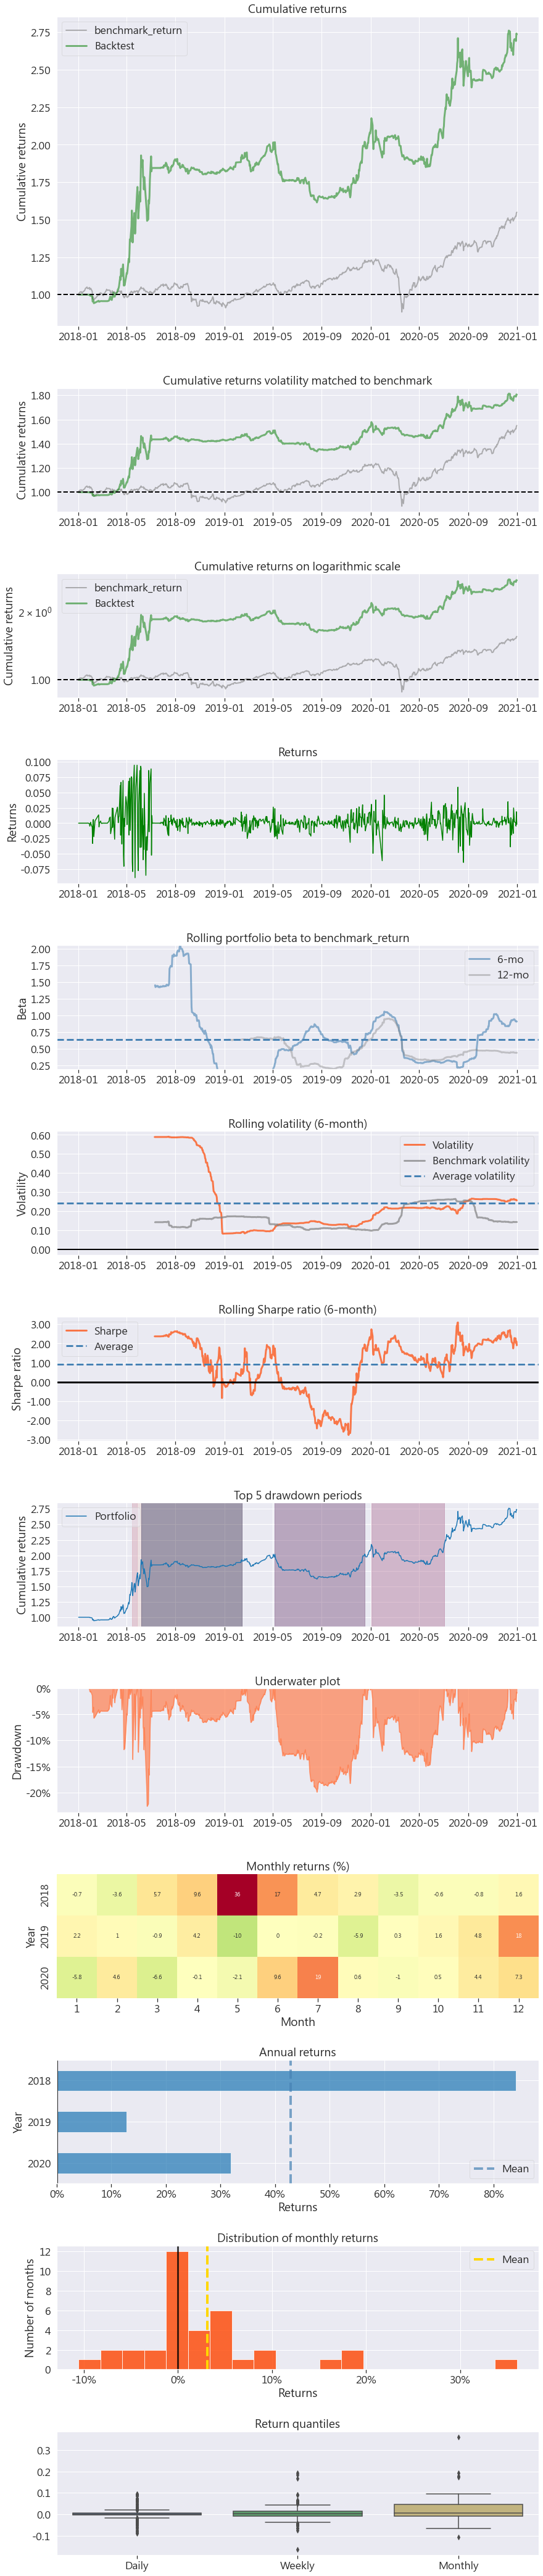

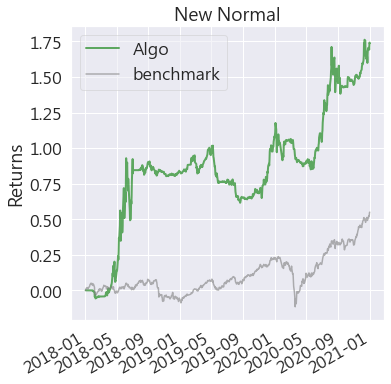

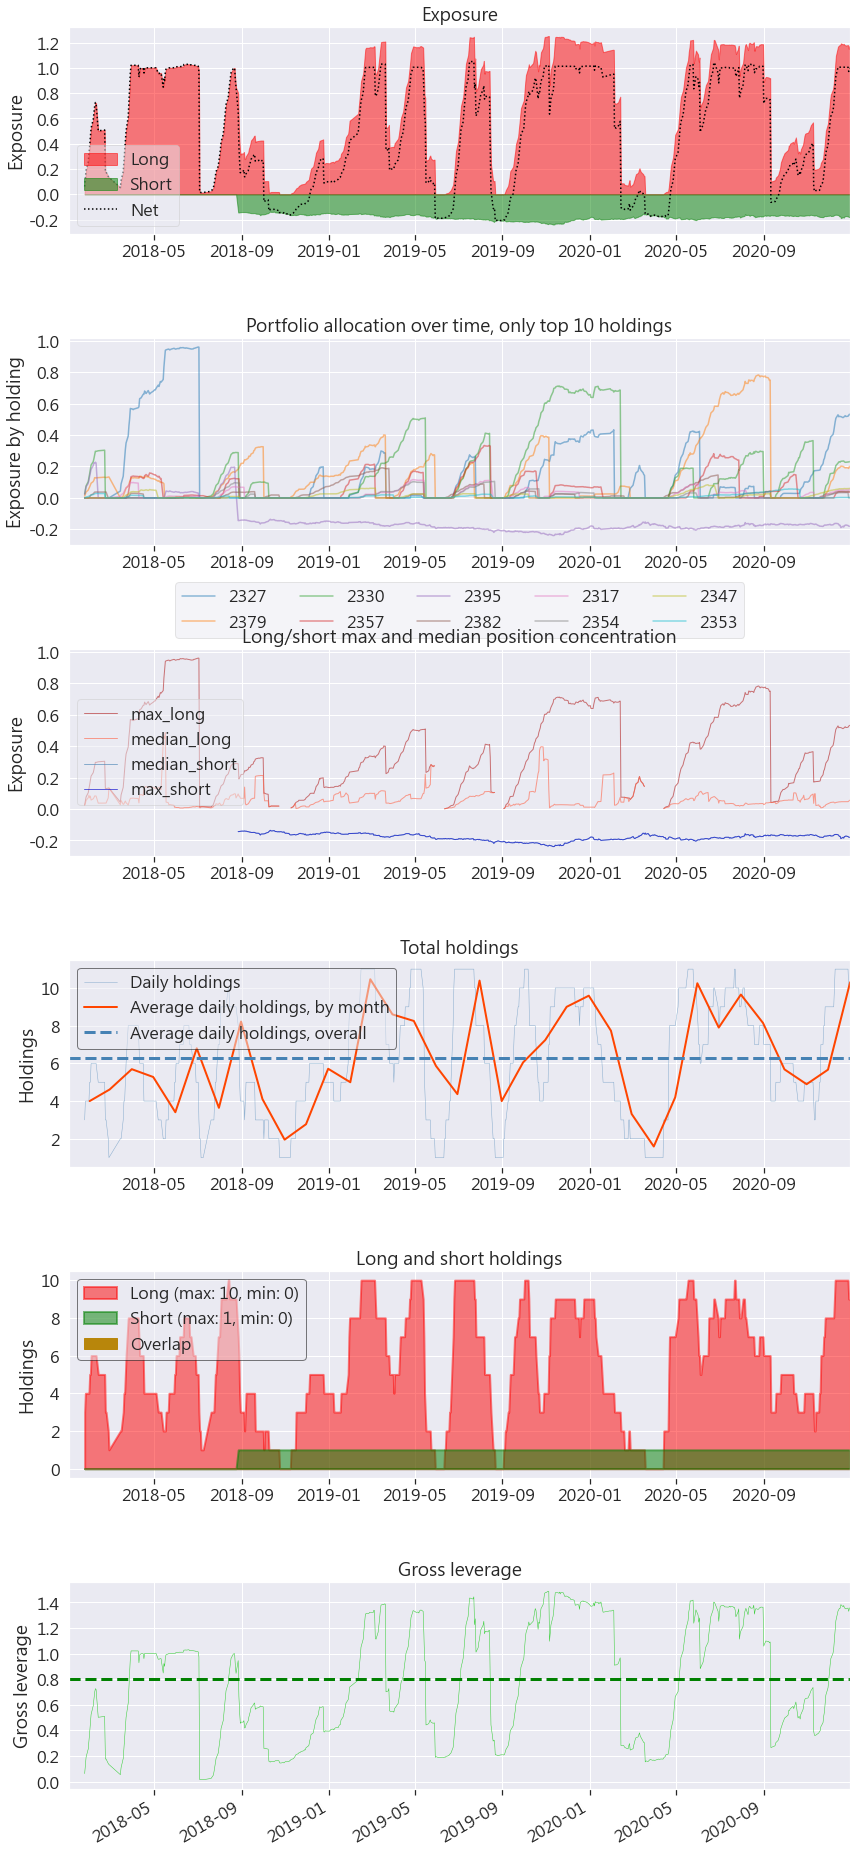

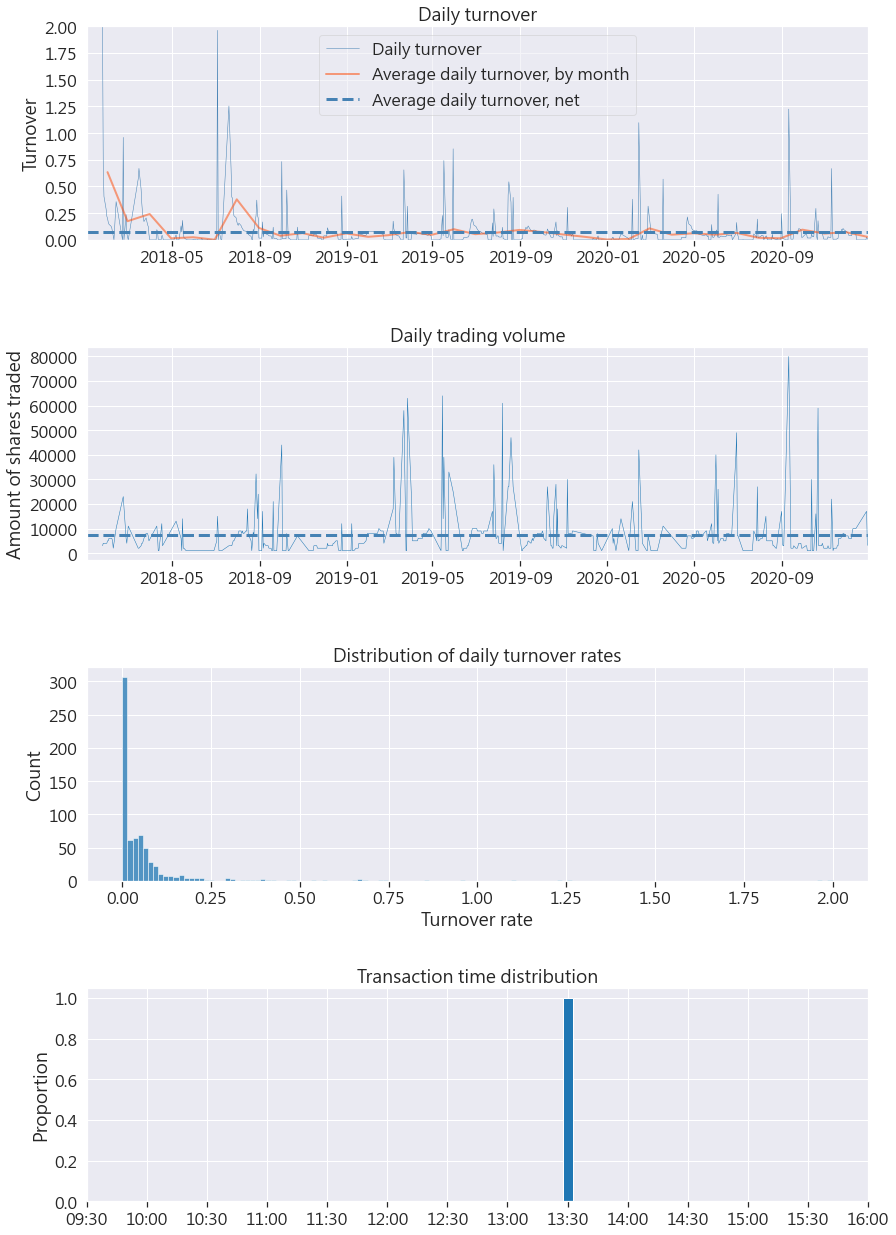

In [29]:
pyfolio.tears.create_full_tear_sheet(returns=returns,
                            positions=positions,
                            transactions=transactions,
                            benchmark_rets=benchmark_rets)